### Changes:

 - Added frequency attribute to neuron object. Is meant to hold firing frequency of the neuron over any given amount of time defined by the function updating the attribute.

In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as RD
from matplotlib import colors
import csv
import copy

In [11]:
#It is important to leave numEquations and stepSize here, as they affect the integration.
numEquations = 4
stepSize = 0.1
simLength = 3000
tarray = np.arange(0,simLength,stepSize)
Ntimes = len(tarray)

spikeThreshold = 5 #Sets the voltage(mV) at which a spike is recorded. 

numnrn = 50 #Number of neurons in the model.

numPV = 10 #Number of PV+ neurons to be forced into the model.


c_e, c_i = 0.2, 0.5 #Percent connectivity. Excitory, Inhibitory.  
p_e, p_i = 0.8, 0 #Probabilty of an existing connection breaking and forming a new connection. Excitory, Inhibitory.
# NOTE inhibitory connections are assigned randomly from the start, so there is no need to rewire.
local_conn = True #When true, new connections can be formed with local connections. When false, only non-local new
# connections are formed.

RD_seed = True # When true, a seed is used to generate connections
seed = 14 # The seed for generating random numbers/list indices. NOTE: defining a seed before a sequence of random events will
# not only define the outcome of the first random choice/event, but ALSO the following ones. So we only need one seed.

Idrive_E_min, Idrive_E_max = -0.05, -0.05 #Applied current range for excitatory neurons.
Idrive_PV_min,Idrive_PV_max = -0.2, -0.2 #Applied current range for inhibitory PV+ neurons.


'''--------------------------------------------------------------------------------'''


class neuron:
        
    def __init__(self):
        self.ID = 0
        self.position = []
        self.connections = [] #List of (1 or 0) connection strengths to other neurons. Is tuple like [[postsyn,conn],[postsyn,conn]...].
        # DO NOT CHANGE self.connections from values of only 1 and 0 because many apects of the program rely on it.
        self.connectionWeights = [] #Holds changes made from plasticity. For self as presynaptic nrn. Values are strengths of
        # signal to other neurons from this neuron.
        self.Input_syn = 0
        self.Input_noise = 0
        self.Input_external = 0
        self.spikeTimes = [] # Set to record a spike when membrane voltage breaches variable spikeThreshold. Units in (ms/stepSize)
        self.prevActivity = 0
        self.neuronsInRange = [] #Tracks the # of neurons in range so as to minimize looping time during connection growth function
        self.solutions = np.zeros(numEquations) #Why does nrn.solutions still function as a comment?
        
        #Things I have added in myself:
        self.spike = False #Determines whether the neuron has already spiked or not. 
        self.Idrive = 0
        self.color = '' #Color of neuron for graphing.
        self.conn_in = [] #Connections coming in from other neurons. Sum is the in-degree of the neuron. Note, not tuple like self.connections.
        # Format is 1D list of connection strengths, where list index is presynaptic neuron. 
        self.category = 'Excitatory' #Labels the neuron type. Default is excitatory, can be chanegd to inhibitory. 
        self.gsyn = 1 # Connection strength multiplier.
        self.pair_spiketimes = np.zeros(numnrn) #Pair spike times for outgoing connections. Note that this only holds the most recent pair spiketime for each conn.
        self.start_noise = 0 #Starting step time for noise when it occurs (mV/stepSize). 
        self.backbone_ID = 0 # backbone_ID=0 will be used to designate lower E neurons and -1 for inhibitory neurons.
        self.spike_gaussian = [] #List of gaussian curves, each centered at the time a neuron spikes. Each index in list corresponds to a t_ind time.
        self.plas_on = True #Boolean determining whether or not to change plasticity of connections TO and FROM this nrn. 
        self.cw_in_history = [] #Connection weight history. Holds plasticity connection weights coming IN (this nrn as postsyn).
        # Set up as [[[weight from nrn 0, weight from nrn 1, ... ],time(ms)] ,...], one weight list for each milisecond.
        # List set up to skip first 500 ms because we don't want plasticity due to transient behaviors. Note the default
        # value for connections and non-existent connections is 1. 
        self.scatter_color = 'grey'
        self.scatter_quad_color = 'grey'
        self.i_current_hist = np.array([[0,time] for time in range(simLength)]) # Net inhibitory current to this neuron
        # every ms. [ [net current, time(ms)] , ...]
        self.frequency = 0 # Firing frequency of neuron.
        
        
def equations(solns_, eqn, Isyn, Idrive,nrn):
    # These equations are parameters are adjusted to fit fast-spiking interneurons.
    
    tempVal = 0
    
    category = nrn.category
    Inoise = nrn.Input_noise #Noise from neuron. Maybe I should put Idrive, solns, etc here as well?
    
    if category == 'Excitatory':
        gks = 0 # We are not modeling ACh in this project
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn + Inoise)/C
            
    elif category == 'SST':
        gks = 0 # We are not modeling ACh in this project
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn)/C
            
    elif category == 'PV+':
        C = 1 
        gna = 35
        gkdr = 9
        gl = 0.1
        Vna = 55
        Vk = -90
        Vl = -65    
        if(eqn == 0):
            a_h = 0.07*np.exp(-(solns_[3]+58)/20)
            b_h = 1/(np.exp(-0.1*(solns_[3]+28))+1)
            phi = 5
            tempVal = phi*(a_h*(1-solns_[0]) - b_h*solns_[0])
        elif(eqn == 1):
            a_n = -0.01*(solns_[3]+34)/(np.exp(-0.1*(solns_[3]+34))-1)
            b_n = 0.125*np.exp(-(solns_[3]+44)/80)
            phi = 5
            tempVal = phi*(a_n*(1-solns_[1])-b_n*solns_[1])
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            a_m = -0.1*(solns_[3]+35)/(np.exp(-0.1*(solns_[3]+35))-1)
            b_m = 4*np.exp(-(solns_[3]+60)/18)
            m = a_m/(a_m+b_m)
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                        - gl*(solns_[3]-Vl) + Idrive - Isyn)/C
        
    return tempVal





def RK4(t_ind):
    
    global neuron
    
    for nrn in neurons:
        
        
        solns = nrn.solutions
        Isyn = nrn.Input_syn
        Idrive = nrn.Idrive
        k1 = np.zeros(numEquations)
        k2 = np.zeros(numEquations)
        k3 = np.zeros(numEquations)
        k4 = np.zeros(numEquations)
        
        init_solns = solns
        
        #Calculates the k1 variables
        for ii in range(len(solns)):
            k1[ii] = stepSize*equations(solns, ii,Isyn,Idrive,nrn)

        #Calculates the k2 variables
        for ii in range(len(solns)):
            k2[ii] = stepSize*equations(solns+k1/2, ii,Isyn,Idrive,nrn) #important fix done here. solns must be advanced by k
                                                                    #for calculation of the next k variable.
        #Calculates the k3 variables
        for ii in range(len(solns)):
            k3[ii] = stepSize*equations(solns+k2/2, ii,Isyn,Idrive,nrn) 

        #Calculates the k4 variables
        for ii in range(len(solns)):
            k4[ii] = stepSize*equations(solns+k3, ii,Isyn,Idrive,nrn)
        
        #Updates the general solution
        for ii in range(len(solns)):
            solns[ii] = init_solns[ii] + (k1[ii] + 2*k2[ii] + 2*k3[ii] + k4[ii])/6 
            nrn.solutions[ii] = solns[ii]
            
            
            
def init_nrn(numnrn): #initializes neurons and assigns ID, connections, weights, etc. 
    global neuron
    neurons = [] #List containing neuron objects
    nconn_Mat = [np.empty(3)] # 2D matrix for storing new connections.
    
    if RD_seed: # When true, the simulation will be reproducable entirely (all connections, neuron assignments, initial coniditions).
        RD.seed(seed)
    
    def count_PV(neurons): # A function for counting the number of SST neurons.
        count = 0
        for nrn in neurons:
            if nrn.category == 'PV+':
                count += 1
        return count

    
    for i in range(numnrn):  
        neurons = np.append(neurons,neuron()) #Intiallizes numnrn number of neurons
        
        
    #This for loop ensures that exactly numPV number of E neurons are changed to PV.
    for i in range(numPV):
        changed_to_PV = False #Keeps loop running until excitatory neuron is found to change to PV neuron.
        while changed_to_PV == False: #Loop mentioned above.
            nrn = RD.choice(neurons) #grabs one neuron object at random (available for editing)
            if nrn.category == 'Excitatory': #If true, turns excitatory neuron to PV. If neuron is not Excitatory, while loop runs again.
                nrn.category = 'PV+'
                changed_to_PV = True
                
    #Create list of only E neurons.
    Eneurons = []
    for nrn in neurons:
        if nrn.category == 'Excitatory':
            Eneurons.append(nrn) #Note that even though this is a different list than neurons, the neuron objects within can be
            # changed all the same like they were in neurons. 


    ID = 0
    for nrn in neurons: #assigns neurons in list their IDs, init voltage, Idrive, etc.
        nrn.ID = ID
        ID += 1 
        nrn.spikeTimes = []
        nrn.solutions = [RD.random(),RD.random(),RD.random(),RD.uniform(-55,-20)] #Initial conditions of each neuron. Initial voltage randomly assigned between -55 and -20 mV.
        nrn.connectionWeights = [1]*numnrn #Creates a list of all connection weights to other neurons at value 1. 

        if nrn.category == 'Excitatory':
            nrn.Idrive = round(RD.uniform(Idrive_E_min, Idrive_E_max),3) #Random value between min and max rounded to 1 decimal places
            nrn.color = 'Blue'
            
        if nrn.category == 'PV+':
            nrn.Idrive = round(RD.uniform(Idrive_PV_min,Idrive_PV_max),3)
            nrn.color = 'darkorange'

    
    conn_Matrix = np.zeros((numnrn,numnrn)) #initializes matrix of zeros with numnrn x numnrn size. Row = nrn ID, Column = connected nrn ID.
    # Fills matrix with connectivity based on proximity. conn_span neurons to right and left are given connections. 
    for row_index, row in enumerate(conn_Matrix):
        for column_index, conn in enumerate(row):
            
            if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
                conn_span = int(c_e*numnrn/2) #number of neurons to be connected on either side of a neuron.

                #sets neurons at +- conn_span from diagonal to full connectivity.
                if column_index >= row_index-conn_span and column_index <= row_index+conn_span:
                    conn = 1 
                #Full connectivity at edge case of first neurons connected to last neurons in ring.
                elif row_index-conn_span < 0 and column_index >= numnrn+row_index-conn_span:
                    conn = 1
                #Full connectivity at edge case of last neurons connected to first neurons in ring.
                elif row_index+conn_span > (numnrn-1) and column_index <= row_index-numnrn+conn_span:
                    conn = 1 
                #All other neurons have zero connectivity.
                else:
                    conn = 0
                # Sets diagonal entries to zero.
                if column_index == row_index:
                    conn = 0
                    
            elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+': # If the presynaptic neuron is inhibitory.
                if RD.random() <= c_i and column_index != row_index: # if a random between 0 and 1 is less than the connectivity percent. 
                    conn = 1
                else:
                    conn = 0
                    
            row[column_index] = conn  #Assigns the local connections.
        conn_Matrix[row_index] = row

    # Changes connections based on proability p. 
    for row_index, row in enumerate(conn_Matrix): 
        row_temp = row.copy() #used to store changes while deleting connections from new_conn_list. VERY IMPORTANT TO USE .copy()
         # otherwise row will change when row_temp is changed. This is how assignment works. 
        if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
            conn_span = int(c_e*numnrn/2) #number of neurons to be connected on either side of a neuron.
            p = p_e
        elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+':
            conn_span = int(c_i*numnrn/2)
            p = p_i 

        for column_index, conn in enumerate(row):
            
            if conn != 0: #only for existing connections.
                if RD.random() <= p: # RD.random() selects random float between 0 and 1.

                    if local_conn == True: # Allows new local connections.
                        new_conn_list = np.append(np.arange(0,row_index,1),np.arange(row_index+1,numnrn,1)) #Creates list of
                        #all nrn IDs besides self.
                    if local_conn == False: #No new local connections.
                        #List of all nrns except local and self. Very gross and uses heaviside functions. May be simplifiable. 
                        new_conn_list = np.append(np.arange(numnrn - numnrn*np.heaviside(row_index-conn_span-1, 1)
                                    +(row_index+conn_span-numnrn+1)*np.heaviside(row_index+conn_span-numnrn,1),row_index-conn_span,1),
                                    np.arange(row_index+conn_span+1,(numnrn+row_index-conn_span)-
                                    (row_index-conn_span)*np.heaviside(row_index-conn_span, 1),1))
                     
                    for index, val in enumerate(row_temp):#Deletes established conns from new_conn_list, preventing double connections.

                        if val != 0: #Sorts out only established conns.
                            delindex = np.where(new_conn_list == index) #Finds where est. conn lies in new_conn_list.
                            if len(delindex[0]) > 0: #Stops error from having nothing to delete when local_conn = False. 
                                delindex = delindex[0][0] #grabs useful integer.
                                new_conn_list = np.delete(new_conn_list, delindex) #deletes from possible conns. 
    
                    nconn = RD.choice(new_conn_list) #Randomly selects one neuron to connect to. 
                    nconn_info = [[row_index, column_index, nconn]] # [neuron #, old connection, new connection]. Must be 2D.
                    nconn_Mat = np.concatenate((nconn_Mat,nconn_info)) #Adds this info to a matrix for later use.
                    
                    #Updates values of the array used in determining new connections. 
                    row_temp[int(column_index)] = 0 
                    row_temp[int(nconn)] = 1


    nconn_Mat = np.delete(nconn_Mat,0,0) #Removes np.empty dummy row from matrix.
    
    #Apply new connection changes.
    for info in nconn_Mat:
        conn_Matrix[int(info[0]),int(info[1])] = 0 #Sets old connection to zero.
        conn_Matrix[int(info[0]),int(info[2])] += 1 #Establishes connection or adds another connection.

    nc_Matrix = np.empty((numnrn,numnrn,2)) #Empty matrix to hold final values. nc means neuron # and connection strength. 
    count = 0
    # Creates 3D array, nc_matrix, storing (nrn #, conn strength to nrn receiving Isyn)
    for row in conn_Matrix:
        conn_tuple = list(enumerate(row)) #list of tuples with info (postsyn nrn #, recieving nrn conn strength)
        nc_Matrix[count] = conn_tuple 
        count += 1

    
    #Assigns neuron objects the list of tuple connections. 
    for nrn in neurons:
        nrn.connections = nc_Matrix[nrn.ID] #Outgoing connections for nrn.
        nrn.conn_in = nc_Matrix[:,nrn.ID][:,1]# Incoming connections for nrn. [0,0,1,1] would mean this neuron recieves no
        # signal from neurons 0 and 1, and full signal from neurons 2 and 3. 
        
        
        
        
    return neurons,nc_Matrix




    
            
def updateSyn(t_ind): #Gives synaptic input to all neurons on connection list
    #Includes changes in synaptic strengths. t_start is the time at which the presynaptic neuron's voltage breaches -20 mV.
    # Has been changed to normalize strength of inputs to a neuron by number of inputs. I.e sum of all inputs comes to w_max. 
    t_temp = 0 
    global neuron

    # AMPA connections
    w_EE = 0.05
    w_EI = 0.15
    # GABA A connections
    w_II = 0.05
    w_IE = 0.25
    # GABA B connections
    w_II_B = 0.0
    w_IE_B = 0.01
    
    tau = 0.5 #Time constant for fast-acting receptors.
    tau_B = 50 # Time constant for GABA B receptors, slow-acting.
    
    for nrn in neurons:# presynaptic neurons.         
        if len(nrn.spikeTimes) > 0: # To prevent errors of calling [-1] from an array without any entries. Can change to be l > 2, 3 ...
            t_temp = nrn.spikeTimes[-1] #grabs time this neuron spikes at.

            for conn in nrn.connections: #Gives all postsynaptic neurons Isyn corrspondping to their voltage.
                V = neurons[int(conn[0])].solutions[3] #Voltage of postsynaptic neuron. Note conn[1] is the connection strength and conn[0] is the ID.
                Isyn = 0 
                
                if nrn.category == 'SST' or nrn.category == 'PV+': # Handles GABA A and B receptors in postsyn  neurons.
                    E_syn = -75 #Chloride reversal potential. 
                    if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For I-I connections.
                        for w,t in (w_II,tau),(w_II_B,tau_B): #Sends two signals, one with w_II/tau and one with w_II_B/tau_B. 
                            Isyn += conn[1]*(w)*np.exp(-stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t is tau here. 
                    if neurons[int(conn[0])].category == 'Excitatory': # For I->E connections.
                        for w,t in (w_IE,tau),(w_IE_B,tau_B):
                            Isyn += conn[1]*(w)*np.exp(-stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t = tau again.
                        
                        # Recording inhibitory input to each LE neuron:
                        if neurons[int(conn[0])].backbone_ID == 0 and t_ind % (1/stepSize) == 0:
                            for w,t in (w_IE,tau),(w_IE_B,tau_B):
                                neurons[int(conn[0])].i_current_hist[int(t_ind*stepSize)][0] += conn[1]*(w)*np.exp(-stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t = tau again.
                                #print(nrn.i_current_hist[int(t_ind*stepSize)][0], 'time ', t_ind*stepSize)
                            
                if nrn.category == 'Excitatory':
                    E_syn = 0 # Sodium reversal potential. E_syn = 0 for excitory synapse and E_syn = -75 mV for inhibitory synapse
                    if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For E->I connections.
                        Isyn = conn[1]*(w_EI)*np.exp(-stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                    if neurons[int(conn[0])].category == 'Excitatory': # For E-E connections.
                        Isyn = nrn.connectionWeights[int(conn[0])]*conn[1]*(w_EE)*np.exp(-stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                    
                neurons[int(conn[0])].Input_syn += Isyn #Isyn going to Postsynaptic neuron.


    
    
    
            
def updateSpikeTime(t_ind):
    global neuron
    tau = 10 # Time constant for exponential function in ms.
    
    skip_time = 20 #Time before spikes start being recorded (in ms).
    
    for nrn in neurons:

        # Recording spike times:
        if nrn.solutions[3] >= spikeThreshold and nrn.spike == False and (t_ind*stepSize) > skip_time: #Selects spikes, skips anything before the first "skip_time" ms. 
            nrn.spikeTimes = np.append(nrn.spikeTimes, t_ind) #Records (time/stepSize) of a spike.
            nrn.spike = True   
                    
        if nrn.solutions[3] <= -30 and nrn.spike == True: #Resets the spiking status, allows for next spike to be recorded. 
            nrn.spike = False
            
            
            
def zeroTempVars(): #Zeros all variables to prevent accidental accumulation of unwanted terms. Just a safety measure, good habit.
        #Note: Do not zero solutions, because they are used in calculating next solutions. 
        global neuron
        for nrn in neurons:
            nrn.Input_syn = 0 #Zeroed because ISyn must be added to account for input from multiple neurons. If Isyn was
            # simply assigned, the Isyn would not accumulate. But now it must be zeroed. 
            
            
            
def plot_conn_raster(start_time, nc_Matrix): #Plots raster plot and connectivity matrix.
    plot_raster = True
    plot_connection_mat = False
    
    list_i,list_e = [],[]
    for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
        if nrn.category == 'SST' or nrn.category == 'PV+':
            list_i.append(nrn) #Appends full nrn object (not just the ID) to make sorting by gsyn easier.
        if nrn.category == 'Excitatory':
            list_e.append(nrn)
            
    neuron_list = list_i + list_e #Adds the two lists such that inhibitory neurons come first and excitory second.
    
    
    if plot_raster: #Plots raster plot of neuron spikes. Ordered with inhibitory on the bottom, followed by sorted E neurons.
        fig, ax1 = plt.subplots(1,figsize=(20,5))
        start = start_time/stepSize #time to start plotting from.

        for index, nrn in enumerate(neuron_list):
            spikeTimes_toplot = []

            for t in nrn.spikeTimes: # Runs through spike times of every neuron in 'neuron_list', starting with inhibitory.3
                if t >= start: #only selects times greater than 'start' for plotting.
                    spikeTimes_toplot = np.append(spikeTimes_toplot,t*stepSize)

            index_plot_list = [index]*len(spikeTimes_toplot)
            
            color = nrn.color # Color of spikes plotted for this neuron on raster plot.
                
            ax1.scatter((spikeTimes_toplot),index_plot_list,c=color,s=2) # c controls nrn dot color, s controls dot size.

        ax1.set_title('Raster Plot')
        ax1.set_xlabel('Time (ms)')
        ax1.set_ylabel('Neurons Sorted by Group');
        fig.savefig('C:/Users/satchelm/OneDrive - Umich/Desktop/568 Project Plots/Raster_stim_off.png', format='png')
    
    
    # Reorders the rows of the connection matrix so as to match the sorted raster plot. 
    # Then plots the new matrix.
    if plot_connection_mat:
        reorder_list = []

        for nrn in neuron_list:
            reorder_list.append(nrn.ID)

        reorder_list.reverse() #Reverses order to match the setup of raster plot.
        reor_mat = nc_Matrix[reorder_list] # Creates new matrix reor_mat that is the reordered version of nc_Matrix.

        #Plots pixel-plot of neuron connectivities.
        fig, ax_conn  = plt.subplots(1,figsize=(12,12))
        connplot = ax_conn.imshow(reor_mat[:,:,1], extent=(0,numnrn,0,numnrn), cmap='cividis') #Generates pixel-like plot of connection strengths.
        ax_conn.grid(which='both', axis='both', color='black', linewidth=1)
        ax_conn.set_xticks(np.arange(0,numnrn,1)) #Sets lines for axes, off of which the grid is based.
        ax_conn.set_yticks(np.arange(0,numnrn,1))
        ax_conn.set_title('Raster Plot Order Neuron Connectivity Graphic', size=20)
        ax_conn.set_xlabel('Postsynaptic Neuron',size=12)
        ax_conn.set_ylabel('Presynaptic Neuron',size=12);
        #fig.savefig('C:/Users/satchelm/OneDrive - Umich/Documents/GitHub/EngramsCompetition/568 Project Plots/Conn_Matrix_stim_off.png', format='png')

        
        
        
def rand_Idrive(percent,new_Idrive): #Assigns to percent number of excitatory neurons a different Idrive value.
    
    global neuron
    E_neurons = []
    
    for nrn in neurons:
        if nrn.category == 'Excitatory':
            E_neurons.append(nrn) #Adds excitatory neuron objects to a seperate list.

    num_nrns_tochange = int(len(E_neurons)*percent) #The number of excitatory neurons to change the Idrive for.

    for i in range(num_nrns_tochange):
        E_nrn = RD.choice(E_neurons) #randomly selects an excitatory neuron.
        neurons[E_nrn.ID].Idrive = new_Idrive #Assigns the new Idrive.
        #neurons[E_nrn.ID].color = 'Red' #Changes color of neuron for identification in raster plot. 
        

        
        
        
        
def reset_Idrive():  # Resets all excitatory neurons to have Idrive_E_max.
    global neuron
    
    for nrn in neurons:
        if nrn.category == 'Excitatory':
            nrn.Idrive = Idrive_E_max

            
        

        
def frequency(t_start,t_stop): # Function for updating the frequency of excitatory neurons in a network within a given time
    # interval [t_start,t_stop].
    global neuron
    
    ind_start, ind_stop = t_start/stepSize, t_stop/stepSize #Turns times into indices.
    
    for nrn in neurons:
        nrn.frequency = 0 #Resets firing frequency of neuron.
        
        spikeTimes = np.array(nrn.spikeTimes)
        spikeTimes_in_interval = spikeTimes[(ind_start < spikeTimes) & (spikeTimes < ind_stop)] #Selects only spike time indices that fall
        # between ind_start and ind_stop.
            
        if len(spikeTimes_in_interval) > 1: # Only considers neurons that have spiked at least twice in the interval.
            # Calculates frequency of neuron firing in the interval and updates attribute. 
            nrn.frequency = round((len(spikeTimes_in_interval)-1)*1000/(stepSize*(spikeTimes_in_interval[-1]-spikeTimes_in_interval[0])) ,3)

In [3]:
neurons,nc_Matrix = init_nrn(numnrn) #initializes neurons and creates universal list.

def mainProgramLoop():
    
    for t_ind in range(Ntimes):
        
        #Records timing of spikes (in t/stepSize)
        updateSpikeTime(t_ind)
        #Updates the input synaptic current to be used in RK4
        updateSyn(t_ind)
        #A function to update the solutions for all neurons' D.E.s
        RK4(t_ind)

        zeroTempVars() #Resets temporary variables like Isyn
        
        if t_ind*stepSize == 1000 or t_ind*stepSize == 2000:
            reset_Idrive()
            rand_Idrive(0.3,0.5)
        
    return 

mainProgramLoop()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/satchelm/OneDrive - Umich/Desktop/568 Project Plots/Raster_stim_off.png'

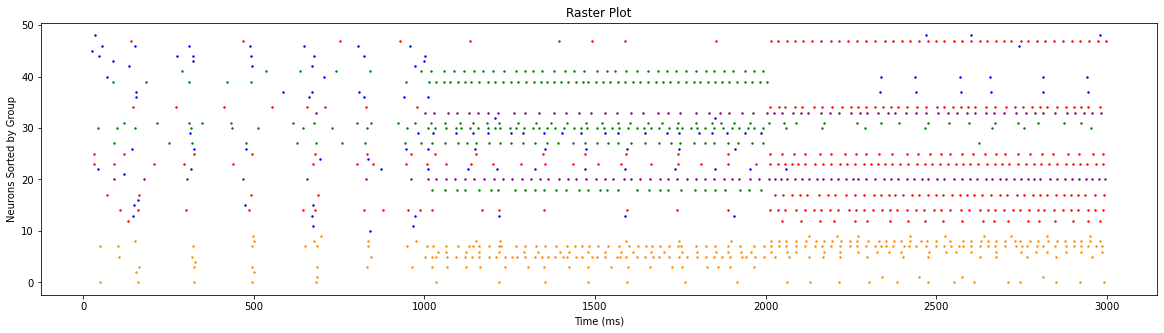

In [12]:
def apply_freq(): # Runs frequency calculation and color changing
    
    for nrn in neurons: #Sets all E neurons to blue initially. 
        if nrn.category == 'Excitatory':
            nrn.color = 'Blue'
    
    freq_threshold = 20 #Threshold of neuron frequency to be considered part of an engram (in Hz). 
    
    frequency(1000,2000)
    for nrn in neurons:

        if nrn.category == 'Excitatory' and nrn.frequency > freq_threshold:
            nrn.color = 'Green'
#         elif nrn.category == 'Excitatory' and nrn.frequency < freq_threshold:
#             nrn.color = 'Blue'


    frequency(2000,3000)
    for nrn in neurons:

        if nrn.category == 'Excitatory' and nrn.frequency > freq_threshold and nrn.color == 'Green':
            nrn.color = 'purple'
        if nrn.category == 'Excitatory' and nrn.frequency > freq_threshold and nrn.color == 'Blue':
            nrn.color = 'Red'
            
    plot_conn_raster(0, nc_Matrix)
    
apply_freq()